<a href="https://www.kaggle.com/code/suryateja35/30day-sales-forecast?scriptVersionId=212308517" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
from prophet import Prophet

In [2]:
file_path = '/kaggle/input/sales-transaction/Sales_transaction_gross_sales.csv'
sales_data = pd.read_csv(file_path)

In [3]:
# Convert 'TRANSACTION_DATE' to datetime format
sales_data['TRANSACTION_DATE'] = pd.to_datetime(sales_data['TRANSACTION_DATE'])

In [4]:
# Remove rows with negative sales values
sales_data = sales_data[sales_data['ESTIMATED_GROSS_PROFIT_AMOUNT'] >= 0]

In [5]:
# Aggregate data by day to ensure one entry per day
daily_sales = sales_data.groupby('TRANSACTION_DATE')['ESTIMATED_GROSS_PROFIT_AMOUNT'].sum().reset_index()
print(daily_sales)

     TRANSACTION_DATE  ESTIMATED_GROSS_PROFIT_AMOUNT
0          2020-01-02                       19759.60
1          2020-01-03                       17195.57
2          2020-01-05                       17485.47
3          2020-01-06                       22110.86
4          2020-01-07                       14211.80
...               ...                            ...
1589       2024-12-02                      767568.56
1590       2024-12-03                      534608.51
1591       2024-12-04                      530186.29
1592       2024-12-05                      532576.96
1593       2024-12-06                        1117.94

[1594 rows x 2 columns]


In [6]:
# Generate a continuous date range
date_range = pd.date_range(start=daily_sales['TRANSACTION_DATE'].min(), 
                           end=daily_sales['TRANSACTION_DATE'].max())
print(date_range)

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-04', '2020-01-05',
               '2020-01-06', '2020-01-07', '2020-01-08', '2020-01-09',
               '2020-01-10', '2020-01-11',
               ...
               '2024-11-27', '2024-11-28', '2024-11-29', '2024-11-30',
               '2024-12-01', '2024-12-02', '2024-12-03', '2024-12-04',
               '2024-12-05', '2024-12-06'],
              dtype='datetime64[ns]', length=1801, freq='D')


In [7]:
missing_dates = pd.date_range(start=daily_sales['TRANSACTION_DATE'].min(), 
                              end=daily_sales['TRANSACTION_DATE'].max()).difference(daily_sales['TRANSACTION_DATE'])
print(f"Missing dates before reindexing: {missing_dates}")

Missing dates before reindexing: DatetimeIndex(['2020-01-04', '2020-01-11', '2020-01-18', '2020-01-25',
               '2020-02-01', '2020-02-08', '2020-02-15', '2020-02-22',
               '2020-02-23', '2020-02-24',
               ...
               '2024-09-29', '2024-10-05', '2024-10-12', '2024-10-19',
               '2024-10-26', '2024-11-02', '2024-11-09', '2024-11-16',
               '2024-11-17', '2024-11-24'],
              dtype='datetime64[ns]', length=207, freq=None)


In [8]:
missing_dates_df = pd.DataFrame({'Missing Dates': missing_dates})
print(missing_dates_df.head(10))  # Check the first 10 missing dates

# Check the day of the week for missing dates
missing_dates_df['Day of Week'] = missing_dates_df['Missing Dates'].dt.day_name()
print(missing_dates_df['Day of Week'].value_counts())


  Missing Dates
0    2020-01-04
1    2020-01-11
2    2020-01-18
3    2020-01-25
4    2020-02-01
5    2020-02-08
6    2020-02-15
7    2020-02-22
8    2020-02-23
9    2020-02-24
Day of Week
Saturday    176
Sunday       21
Monday        6
Friday        3
Tuesday       1
Name: count, dtype: int64


In [9]:
#Merge with the full date range, filling missing dates with 0
daily_sales = daily_sales.set_index('TRANSACTION_DATE').reindex(date_range, fill_value=0).reset_index()
daily_sales.rename(columns={'index': 'ds', 'ESTIMATED_GROSS_PROFIT_AMOUNT': 'y'}, inplace=True)


In [10]:
import numpy as np
daily_sales['y'] = daily_sales['y'].replace(0, np.nan)  # Replace zeros (only for weekdays) with NaN
daily_sales['y'] = daily_sales['y'].interpolate(method='linear')  # Linear interpolation for missing values
daily_sales['y'] = daily_sales['y'].fillna(0)  # Fill remaining NaNs (e.g., weekends) with 0

In [11]:
# Identify and cap outliers
q1 = daily_sales['y'].quantile(0.25)
q3 = daily_sales['y'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Replace outliers with the bounds
daily_sales['y'] = daily_sales['y'].clip(lower=lower_bound, upper=upper_bound)


In [12]:
model = Prophet()
model.add_seasonality(name='weekly', period=7, fourier_order=3)
model.add_seasonality(name='yearly', period=365.25, fourier_order=10)
model.fit(daily_sales)

13:11:28 - cmdstanpy - INFO - Chain [1] start processing
13:11:28 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
#Forecast the next 3 months (90 days)
future_dates = model.make_future_dataframe(periods=30)  # Add 90 days to the time series
forecast = model.predict(future_dates)

In [14]:
forecast.to_csv("/kaggle/working/sales_forecast_corrected.csv", index=False)
print("Forecast saved as 'sales_forecast_corrected.csv'.")

Forecast saved as 'sales_forecast_corrected.csv'.


             ds         trend    yhat_lower     yhat_upper   trend_lower  \
0    2020-01-02  30012.186348 -20146.082446   80466.159657  30012.186348   
1    2020-01-03  30161.081061 -18355.076752   77947.558152  30161.081061   
2    2020-01-04  30309.975774 -49554.525802   49954.243365  30309.975774   
3    2020-01-05  30458.870487 -52498.095310   44718.253529  30458.870487   
4    2020-01-06  30607.765200  41702.880516  141059.509351  30607.765200   
...         ...           ...           ...            ...           ...   
1826 2025-01-01  84299.439113  39679.436803  142551.509782  84272.554311   
1827 2025-01-02  84292.079968  33025.078771  131053.592439  84262.301107   
1828 2025-01-03  84284.720823  35646.770880  130326.341749  84249.452003   
1829 2025-01-04  84277.361679   5631.584099  102845.898751  84238.557364   
1830 2025-01-05  84270.002534   3690.206423  102682.360501  84227.721387   

       trend_upper  additive_terms  additive_terms_lower  \
0     30012.186348      186

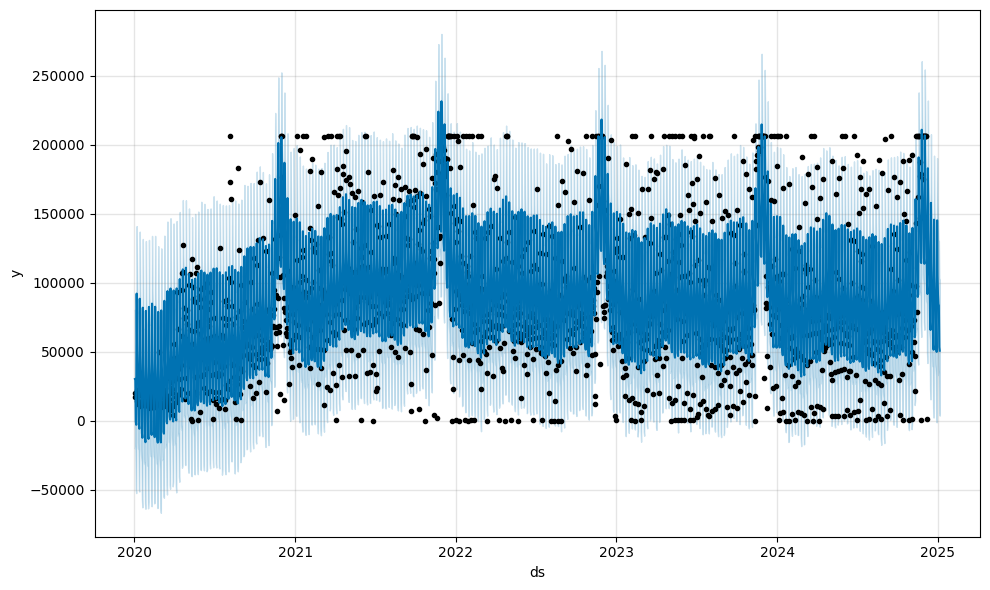

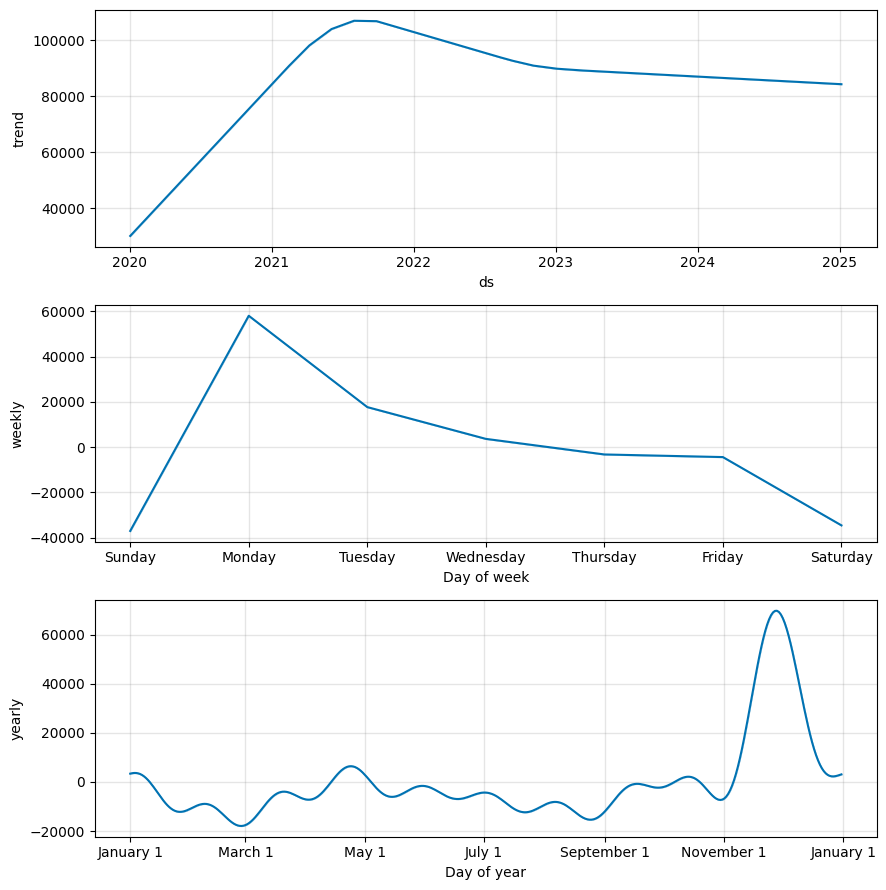

In [15]:
model.plot(forecast)
model.plot_components(forecast)
print(forecast)

In [16]:
daily_sales['y'] = daily_sales['y'].replace(0, np.nan)
daily_sales['y'] = daily_sales['y'].interpolate()  # Linear interpolation for missing/zero values

In [17]:
from sklearn.metrics import mean_squared_error
# Actual values
actual = daily_sales['y']

# Predicted values (match the dates to actual data)
predicted = forecast.loc[:len(actual)-1, 'yhat']

In [18]:
adjusted_actual = np.where(actual == 0, np.nan, actual)
mape = np.nanmean(np.abs((adjusted_actual - predicted) / adjusted_actual)) * 100
print(f"MAPE: {mape}%")

MAPE: 1581.4272912316158%


In [19]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 38080.58113050502


In [20]:
comparison = pd.DataFrame({'Actual': actual, 'Predicted': predicted})
print(comparison.head(10))

     Actual     Predicted
0  19759.60  30198.615425
1  17195.57  29351.641934
2  17340.52   -616.503565
3  17485.47  -2986.458566
4  22110.86  92148.381390
5  14211.80  51620.669321
6  12666.62  37285.624559
7  14582.29  29967.700665
8  12302.08  28257.027480
9  12693.34  -2605.153399
